# Lab 11

Hüseyin Anil Gündüz

## Imports

In [1]:
import random
import shutil
import urllib.request
from functools import reduce, partial
from math import ceil
from pathlib import Path
from typing import List, Optional, Callable, Tuple, Dict

import matplotlib.pyplot as plt
import torch
from PIL import Image
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import nn, Tensor
from torch.distributions import Normal
from torch.optim import Adam, Optimizer
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

set_matplotlib_formats('png', 'pdf')

## Exercise 1

In this exercise we will get acquainted with the KL divergence for normal distributions.
First, let $p(x)=\mathcal{N}(\mu_1,\sigma_1^2)$ and $q(x)=\mathcal{N}(\mu_2,\sigma_2^2)$
and show that

\begin{equation}
\text{KL}(q||p)
= \mathbb{E}_{x\sim q}\left[\log\frac{q(x)}{p(x)}\right]
=\log\frac{\sigma_1}{\sigma_2}+\frac{\sigma_2^2+(\mu_1-\mu_2)^2}{2\sigma_1^2} -\frac 1 2
\end{equation}

Now, consider a variational autoencoder that takes a vector as input $\textbf{x}$ and
transforms it into a mean vector $\mu(\textbf{x})$ and a variance vector $\sigma(\textbf{x})^2$.
From these, we derive the latent code $\textbf{z}\sim q(\textbf{z})=\mathcal{N}(\mu(\textbf{x}),\text{diag}(\sigma(\textbf{x})^2))$,
i.e. a multivariate Gaussian in $d$ dimensions with a given mean vector and diagonal
covariance matrix. The prior distribution for $\textbf{z}$ is another $d$-dimensional
multivariate Gaussian $p=\mathcal{N}(\textbf{0},\textbf{1})$.

Now show that:

\begin{equation}
\text{KL}(q||p)= -\frac 1 2 \sum_{i=1}^d \left(1+\log\sigma_i(\textbf{x})^2-\sigma_i(\textbf{x})^2 - \mu_i(\textbf{x})^2 \right)
\end{equation}

Hint: start by showing that $p$ and $q$ can be factorized into a product of independent
Gaussian components, one for each dimension, then apply the formula for the KL
divergence for the univariate case.



### Solution
We analyze each term separately:

\begin{align}
\mathbb{E}_{x\sim q}\left[\log q(x)\right]
&= -\frac 1 2 \log(2\pi\sigma_2^2)+\mathbb{E}\left[-\frac{1}{2\sigma_2^2}\left(x-\mu_2\right)^2\right] \\
&= -\frac 1 2 \log(2\pi\sigma_2^2) -\frac{1}{2\sigma_2^2}\left(\mathbb{E}[x^2]-2\mu_2\mathbb{E}[x]+\mu_2^2\right) \\
&= -\frac 1 2 \log(2\pi\sigma_2^2) -\frac{1}{2\sigma_2^2}\left(\sigma_2^2+\mu_2^2-2\mu_2^2+\mu_2^2\right) \\
&= -\frac 1 2(1+\log(2\pi\sigma_2^2))
\end{align}

and

\begin{align}
\mathbb{E}_{x\sim q}\left[\log p(x)\right]
&= -\frac 1 2 \log(2\pi\sigma_1^2)+\mathbb{E}\left[-\frac{1}{2\sigma_1^2}\left(x-\mu_1\right)^2\right] \\
&= -\frac 1 2 \log(2\pi\sigma_1^2) -\frac{1}{2\sigma_1^2}\left(\mathbb{E}[x^2]-2\mu_1\mathbb{E}[x]+\mu_1^2\right) \\
&= -\frac 1 2 \log(2\pi\sigma_1^2) -\frac{1}{2\sigma_1^2}\left(\sigma_2^2+\mu_2^2-2\mu_1\mu_2+\mu_1^2\right) \\
&= -\frac 1 2 \log(2\pi\sigma_1^2) -\frac{\sigma_2^2+(\mu_1-\mu_2)^2}{2\sigma_1^2}
\end{align}

Now taking the difference:


\begin{align}
\text{KL}(q||p)
&=\mathbb{E}_{x\sim q}\left[\log q(x)\right] - \mathbb{E}_{x\sim q}\left[\log p(x)\right] \\
&=-\frac 1 2(1+\log(2\pi\sigma_2^2))+\frac 1 2 \log(2\pi\sigma_1^2) +\frac{\sigma_2^2+(\mu_1-\mu_2)^2}{2\sigma_1^2} \\
&=-\frac 1 2\left[1+\log(2\pi\sigma_2^2)-\log(2\pi\sigma_1^2)-\frac{\sigma_2^2+(\mu_1-\mu_2)^2}{\sigma_1^2}\right] \\
&=-\frac 1 2\left[1+\log\frac{\sigma_2^2}{\sigma_1^2}-\frac{\sigma_2^2+(\mu_1-\mu_2)^2}{\sigma_1^2} \right] \\
&= \log\frac{\sigma_1}{\sigma_2}+\frac{\sigma_2^2+(\mu_1-\mu_2)^2}{2\sigma_1^2} -\frac 1 2
\end{align}

Moving to the second question, the expression for $p$ can be factorized as follows:

\begin{align}
q(\textbf{z})
&=
  (2\pi)^{-d/2}
  \det(\text{diag}(\sigma(\textbf{x})^2))^{-1/2}
  \exp\left(-\frac 1 2
    (\textbf{z}-\mu(\textbf{x}))^T
    \text{diag}(\sigma(\textbf{x})^2)^{-1}
    (\textbf{z}-\mu(\textbf{x}))
  \right) \\
&=
  (2\pi)^{-d/2}
  \left(\prod_i \sigma_i(\textbf{x})^2\right)^{-1/2}
  \exp\left(
    -\frac 1 2 \sum_i \sigma_i(\textbf{x})^{-2}(z_i-\mu_i(\textbf{x}))^2
  \right) \\
&=
  \prod_{i=1}^d
  (2\pi\sigma_i(\textbf{x})^2)^{-1/2}
  \exp\left(
    -\frac{1}{2\sigma_i(\textbf{x})^2} (z_i-\mu_i(\textbf{x}))^2
  \right) \\
&=
  \prod_{i=1}^d
  \mathcal{N}(z_i|\mu_i(\textbf{x})^2, \sigma_i(\textbf{x})^2)
\end{align}

Where we made use of some convenient properties of diagonal matrices, namely that their
determinant is the product of the elements on the diagonal, and that their inverse is
again diagonal with the elements replaced by their reciprocal.

Now since the mean of $p$ is zero and the covariance is the identity matrix, we have:

\begin{equation}
p(\textbf{z})=\prod_{i=1}^d\mathcal{N}(z_i|0, 1)
\end{equation}

We now plug these into the formula for the KL divergence to get:

\begin{align}
\text{KL}(q||p)
&= \mathbb{E}_{x\sim q}\left[\log q(x)\right] - \mathbb{E}_{x\sim q}\left[\log p(x)\right] \\
&= \mathbb{E}\left[\log\prod_{i=1}^d q(x)\right] - \mathbb{E}\left[\log\prod_{i=1}^d p_i(x)\right] \\
&= \sum_{i=1}^d \mathbb{E}\left[\log q_i(x)\right] - \sum_i \mathbb{E}\left[\log p_i(x)\right] \\
&= \sum_{i=1}^d \mathbb{E}\left[\log\frac{q_i(x)}{p_i(x)}\right] \\
&= \sum_{i=1}^d \left(\log\frac{1}{\sigma_i(\textbf{x})}+\frac{\sigma_i(\textbf{x})^2+\mu(\textbf{x})^2}{2} -\frac 1 2\right) \\
&= -\frac 1 2 \sum_{i=1}^d \left(1+\log\sigma_i(\textbf{x})^2-\sigma_i(\textbf{x})^2 - \mu_i(\textbf{x})^2 \right)
\end{align}


## Exercise 2

In this exercise we are going to implement variational autoencoders (VAEs) on the MNIST
dataset.

In [2]:
train_x = MNIST(root='.data', download=True, transform=ToTensor());

/home/tobias/Projects/lecture_i2dl/exercises/python/.venv/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In a VAE, the encoder outputs mean and variance of a multivariate Gaussian distribution
of the latent codes. Nothing prevents you from using a more complicated distribution in
the same framework, but this is the usual choice. The expected log likelihood is then
approximated by decoding a single sample from this distribution. Moreover, since we need
the model to be differentiable end-to-end, sampling from the latent codes is
re-formulated via the reparametrization trick.

In the following we define a custom VAE module with a few utility functions that allow
convenient managing of the VAE functionalities.

In [3]:

class VAE(nn.Module):

    # We pass the encoder and decoder over the constructor, which gives us more flexibility.
    def __init__(
            self,
            encoder: nn.Module,
            decoder: nn.Module,
            device: torch.device):
        super().__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)
        self.device = device

        # We need a normal distribution for the reparametrization trick
        self.distribution = Normal(0, 1)

    # We define a utility function for sampling the eps with correct shape and device
    def sample_eps(self, sample_shape: Tuple) -> Tensor:
        sampled_eps: Tensor = self.distribution.sample(sample_shape)
        if str(self.device) != 'cpu':
            sampled_eps = sampled_eps.cuda()
        return sampled_eps

    # We output the reconstructed x as well as the latent mu and log variance.
    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor, Tensor]:
        mu, log_var = self.encoder(x)
        std = torch.exp(0.5 * log_var)
        eps = self.sample_eps(std.shape)
        z = mu + eps * std
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    # We define an inference method for encoding input tensors.
    def encode(self, x: Tensor) -> Tensor:
        with torch.no_grad():
            mu, _ = self.encoder(x)
        return mu

    # We define an inference method for reconstructing z tensors.
    def reconstruct(self, z: Tensor) -> Tensor:
        with torch.no_grad():
            x_hat = self.decoder(z)
        return x_hat


Next, we create our encoder and decoder.
The encoder will have two outputs, which is easily done via the `nn.Module` container.

In [4]:

class Encoder(nn.Module):
    def __init__(self, input_size: int, latent_size: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.LeakyReLU()
        )

        self.mu = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=latent_size),
            nn.LeakyReLU()
        )

        self.log_var = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=latent_size),
            nn.LeakyReLU()
        )

    def forward(self, x:Tensor) -> Tuple[Tensor, Tensor]:
        x = self.net(x)
        return self.mu(x), self.log_var(x)


class Decoder(nn.Module):
    def __init__(self, output_size: int, latent_size: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=output_size),
            nn.Sigmoid()
        )

    def forward(self, x:Tensor) -> Tuple[Tensor, Tensor]:
        return self.net(x)


A missing component is a Kullback-Leibler loss function, which we will define
now for two Gaussians:

In [5]:

class KLDivergence:
    def __call__(self, mu: Tensor, log_var: Tensor) -> Tensor:
        return (
            -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / log_var.shape[0]
        )

Exactly like in the previous exercise, we again define our training iteration:

In [6]:

def train_autoencoder(
        vae: VAE,
        optimizer: Optimizer,
        mnist_dataset: MNIST,
        epochs: int,
        batch_size: int,
) -> List[float]:

    rec_loss = nn.MSELoss(reduction='sum')
    kl_loss = KLDivergence()

    train_losses = []

    num_train_batches = ceil(len(mnist_dataset) / batch_size)
    train_loader = DataLoader(mnist_dataset, batch_size, shuffle=True)

    for ep in range(1, epochs + 1):
        total_ep_loss = 0

        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(vae.device).view(x.shape[0], -1)

            x_hat, mu, log_var = vae(x)
            batch_rec_loss = rec_loss(x, x_hat) / batch_size
            batch_kl_loss = kl_loss(mu, log_var) / x.shape[1]
            total_loss = batch_rec_loss + batch_kl_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tREC LOSS:\t{:2.3f}\tKL LOSS:\t{:2.3f}'
                      .format(batch_idx, num_train_batches, float(batch_rec_loss), float(batch_kl_loss)), end='\r')

            total_ep_loss += float(total_loss)

        train_losses.append(total_ep_loss / num_train_batches)
        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}'.format(ep, train_losses[-1], end='\r'))

    return train_losses


Finally, we can initialize all our classes and start the training!
We will choose a latent size of 8.

In [7]:
latent_size = 8
epochs = 2
batch_size = 128


encoder = (
    Encoder(input_size=784, latent_size=8)
)

decoder = (
    Decoder(output_size=784, latent_size=8)
)

vae = (
    VAE(
        encoder=encoder,
        decoder=decoder,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )
)

optimizer = (
    Adam(vae.parameters())
)

train_autoencoder(vae, optimizer, train_x, epochs, batch_size)

EPOCH:	    1	TRAIN LOSS:	49.909	REC LOSS:	36.969	KL LOSS:	0.3041
EPOCH:	    2	TRAIN LOSS:	28.919	REC LOSS:	25.481	KL LOSS:	0.354


[49.90946866505182, 28.918814514745783]

Let us check the reconstruction of a digit:

In [8]:

def plot_reconstruction_grid(vae: nn.Module, mnist_dataset: MNIST) -> None:
    x_samples = mnist_dataset.data[:100] / 255
    z = vae.encode(x_samples.to(vae.device).view(100, -1))
    x_hat = vae.reconstruct(z).detach().cpu().view(100, 28, 28)

    cur_col = 0
    image_list = []
    for _ in range(4):
        image_list.extend(x_samples[cur_col:cur_col + 25])
        image_list.extend(x_hat[cur_col:cur_col + 25])
        cur_col += 25

    image_batch = torch.stack(image_list).unsqueeze(1)
    image_grid = make_grid(image_batch, nrow=25)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

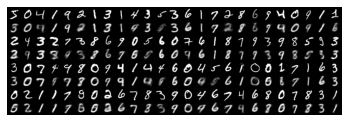

In [9]:
plot_reconstruction_grid(vae, train_x)

It is already quite good for only two training epochs!
Now try to remove the division of the KL by 784, train again and visualize the result.

You should see a gray blob that looks a bit like the average of many digits.
This phenomenon is named _mode collapse_, i.e. the distribution of the generator
collapsed to a single mode that covers the entire dataset, instead of (at least)
one mode for every digit. In VAEs, this is typically caused by a KL term that is
very strong at the beginning of training, and dominates the reconstruction loss.
The optimizer will focus most of its efforts to reduce this term, ending up in a poor local minimum.

A popular method to deal with this issue is _KL annealing_.
It consists in training the network without the KL regularizer for some time, then slowly
increasing the weight of the KL. This procedure allows the network to first learn how to
perform good reconstructions, then to adjust the latent code to conform to a Normal
distribution without erasing progress on the reconstruction.

To implement this behaviour, we define a small object that is able to return the
desired KL weight in the respective epoch.

In [10]:
class KLWeightManager:
    """
    Manager to get the desired KL weight.

    Warm up rounds specify the starting epochs until which the KL weight will be zero.
    The annealing rounds describe the duration of the annealing process.
    E.g., warm up is 5 and and there are 10 annealing rounds, then the first 5 epochs
    will have a KL weight of 0 and from epoch 5 to 15 the weight will be annealed to 1.
    """
    def __init__(self, warm_up_rounds: int, annealing_rounds: int):
        self.warm_up = warm_up_rounds
        self.annealing_rounds = annealing_rounds


    def __call__(self, cur_epoch: int) -> float:
        if cur_epoch < self.warm_up:
            return 0.0
        elif cur_epoch >= self.warm_up + self.annealing_rounds:
            return 1.0
        else:
            progress = cur_epoch - self.warm_up
            return progress / self.annealing_rounds


Let's remove the scaling term in the training loop and integrate the `KLWeightManager`:

In [11]:

def train_autoencoder(
        vae: VAE,
        optimizer: Optimizer,
        mnist_dataset: MNIST,
        epochs: int,
        batch_size: int,
) -> List[float]:

    rec_loss = nn.MSELoss(reduction='sum')
    kl_loss = KLDivergence()
    kl_weighting = KLWeightManager(warm_up_rounds=0, annealing_rounds=5)

    train_losses = []

    num_train_batches = ceil(len(mnist_dataset) / batch_size)
    train_loader = DataLoader(mnist_dataset, batch_size, shuffle=True)

    for ep in range(1, epochs + 1):
        total_ep_loss = 0

        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(vae.device).view(x.shape[0], -1)

            x_hat, mu, log_var = vae(x)
            batch_rec_loss = rec_loss(x, x_hat) / batch_size
            batch_kl_loss = kl_loss(mu, log_var)
            total_loss = batch_rec_loss + kl_weighting(ep) * batch_kl_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print('TRAINING BATCH:\t({:5} / {:5})\tREC LOSS:\t{:2.3f}\tKL LOSS:\t{:2.3f}'
                      .format(batch_idx, num_train_batches, float(batch_rec_loss), float(batch_kl_loss)), end='\r')

            total_ep_loss += float(total_loss)

        train_losses.append(total_ep_loss / num_train_batches)
        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tKL WEIGHT:\t{:.2f}'
              .format(ep, train_losses[-1], kl_weighting(ep), end='\r'))

    return train_losses

In [12]:
latent_size = 8
epochs = 15
batch_size = 128


encoder = (
    Encoder(input_size=784, latent_size=8)
)

decoder = (
    Decoder(output_size=784, latent_size=8)
)

vae = (
    VAE(
        encoder=encoder,
        decoder=decoder,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    )
)

optimizer = (
    Adam(vae.parameters())
)

losses = train_autoencoder(vae, optimizer, train_x, epochs, batch_size)

EPOCH:	    1	TRAIN LOSS:	51.425	KL WEIGHT:	0.201	KL LOSS:	11.118
EPOCH:	    2	TRAIN LOSS:	38.346	KL WEIGHT:	0.403	KL LOSS:	10.036
EPOCH:	    3	TRAIN LOSS:	36.763	KL WEIGHT:	0.605	KL LOSS:	9.5047
EPOCH:	    4	TRAIN LOSS:	36.805	KL WEIGHT:	0.808	KL LOSS:	9.373
EPOCH:	    5	TRAIN LOSS:	37.390	KL WEIGHT:	1.001	KL LOSS:	9.229
EPOCH:	    6	TRAIN LOSS:	36.678	KL WEIGHT:	1.008	KL LOSS:	9.100
EPOCH:	    7	TRAIN LOSS:	36.157	KL WEIGHT:	1.000	KL LOSS:	9.501
EPOCH:	    8	TRAIN LOSS:	35.767	KL WEIGHT:	1.001	KL LOSS:	9.068
EPOCH:	    9	TRAIN LOSS:	35.460	KL WEIGHT:	1.004	KL LOSS:	9.4646
EPOCH:	   10	TRAIN LOSS:	35.196	KL WEIGHT:	1.000	KL LOSS:	9.6550
EPOCH:	   11	TRAIN LOSS:	34.957	KL WEIGHT:	1.004	KL LOSS:	9.8820
EPOCH:	   12	TRAIN LOSS:	34.779	KL WEIGHT:	1.006	KL LOSS:	9.9672
EPOCH:	   13	TRAIN LOSS:	34.555	KL WEIGHT:	1.003	KL LOSS:	10.056
EPOCH:	   14	TRAIN LOSS:	34.407	KL WEIGHT:	1.006	KL LOSS:	10.214
EPOCH:	   15	TRAIN LOSS:	34.269	KL WEIGHT:	1.007	KL LOSS:	10.350


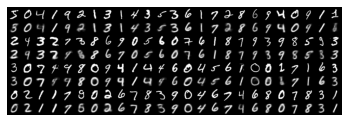

In [13]:
plot_reconstruction_grid(vae, train_x)


It seems like we don't suffer from posterior collaps and our reconstructions look rather
good. It has been shown, that choosing KL weights larger than one can lead to overall
better representations with the downside of worse reconstructions. This framework is
found in literatures as $\beta$-VAE. The correct choice of the KL weight is a difficult
one and depends on the distribution of your dataset and also its dimensionality.

With a VAE we also have a generative model. We could e.g. sample zs from a uniform range
and see what the generator will reconstruct:

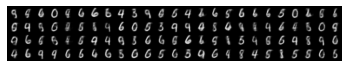

In [14]:
rand_z = torch.rand((100, latent_size), device=vae.device)
generated_samples = vae.reconstruct(rand_z).view(100, 1, 28, 28).detach().cpu()

image_grid = make_grid(generated_samples, nrow=25)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

We can also use the generative decoder to smoothly interpolate between random samples:
(Execute the cell a few times to see the interpolation between other random digits)

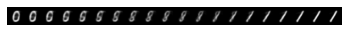

In [15]:
def interpolate_linear(x: Tensor, y: Tensor, steps: int,) -> Tensor:
    cur_weight = 0.0
    weight_incr = 1 / (steps - 1)

    result = torch.zeros((steps, *x.shape))
    if x.is_cuda:
        result = result.cuda()

    for step in range(steps):
        result[step] = torch.lerp(x, y, cur_weight)
        cur_weight += weight_incr

    return result

x_one = train_x.data[torch.randint(0, 60000, (1,))] / 255.
z_one = vae.encode(x_one.view(1, -1).to(vae.device))

x_two = train_x.data[torch.randint(0, 60000, (1,))] / 255.
z_two = vae.encode(x_two.view(1, -1).to(vae.device))

zs = interpolate_linear(z_one, z_two, steps=20)
x_hats = vae.reconstruct(zs).view(20, 1, 28, 28).detach().cpu()

image_grid = make_grid(x_hats, nrow=20)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()